# Network Pruning

In eve-mli, you can perform a pruning operation on network in a lightly way under the help of eve parameter.

In [1]:
# import necessary packages.
# at the beginning, ensure that the eve-mli package is in your python path.
# or you just install it via `pip install eve-mli`.

import os
import time
from datetime import datetime

import random
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import eve
import eve.app
import eve.app.model
import eve.app.trainer
import eve.core
import eve.core.layer

from matplotlib import pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
# build a basic network for trainer
class mnist(eve.core.Eve):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1),
            nn.BatchNorm2d(4),
        )
        self.pruner1 = eve.core.Pruner(eve.core.State(self.conv1))

        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.BatchNorm2d(8),
        )
        self.pruner2 = eve.core.Pruner(eve.core.State(self.conv2))

        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
        )
        self.pruner3 = eve.core.Pruner(eve.core.State(self.conv3))

        self.linear1 = nn.Linear(16 * 4 * 4, 16)
        self.pruner4 = eve.core.Pruner(eve.core.State(self.linear1))

        self.linear2 = nn.Linear(16, 10)

    def forward(self, x):
        conv1 = self.conv1(x)
        pruner1 = self.pruner1(conv1)

        conv2 = self.conv2(pruner1)
        pruner2 = self.pruner2(conv2)

        conv3 = self.conv3(pruner2)
        pruner3 = self.pruner3(conv3)

        pruner3 = th.flatten(pruner3, start_dim=1).unsqueeze(dim=1)

        linear1 = self.linear1(pruner3)
        pruner4 = self.pruner4(linear1)

        linear2 = self.linear2(pruner4)

        return linear2.squeeze(dim=1)

In [3]:
# define a MnistClassifier
# Classifier uses the corss entropy as default.
# in most case, we just rewrite the `prepare_data`.
class MnistClassifier(eve.app.model.Classifier):
    def prepare_data(self, data_root: str):
        from torch.utils.data import DataLoader, random_split
        from torchvision import transforms
        from torchvision.datasets import MNIST

        train_dataset = MNIST(root=data_root,
                              train=True,
                              download=True,
                              transform=transforms.ToTensor())
        test_dataset = MNIST(root=data_root,
                             train=False,
                             download=True,
                             transform=transforms.ToTensor())
        self.train_dataset, self.valid_dataset = random_split(
            train_dataset, [55000, 5000])
        self.test_dataset = test_dataset

        self.train_dataloader = DataLoader(self.train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=4)
        self.test_dataloader = DataLoader(self.test_dataset,
                                          batch_size=128,
                                          shuffle=False,
                                          num_workers=4)
        self.valid_dataloader = DataLoader(self.valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=4)

In [4]:
# store accuracy result
y = {}
def plot():
    global y
    keys, values = list(y.keys()), list(y.values())
    for k, v in y.items():
        plt.plot(v, 
                 color='green' if random.random() > 0.5 else "red", 
                 marker='o' if random.random() > 0.5 else "*", 
                 linestyle='-' if random.random() > 0.5 else ":", 
                 label=k)
    plt.title('accuracy over epoches (train)')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.legend(loc="upper left")
    plt.show()

In [5]:
def train(trainer, exp_name: str = "snn"):
    global y
    # train 10 epoches and report the final accuracy
    y[exp_name] = []
    tic = datetime.now()
    for _ in range(10):
        info = trainer.fit()
        y[exp_name].append(info["acc"])
    info = trainer.test()
    toc = datetime.now()
    y[exp_name] = np.array(y[exp_name])
    print(f"Test Accuracy: {info['acc']*100:.2f}%, Elapsed time: {toc-tic}")

## l1 norm

===> Train
Test Accuracy: 92.38%, Elapsed time: 0:00:51.982259
===> Pruning
Test Accuracy: 92.35%, Elapsed time: 0:00:52.857012


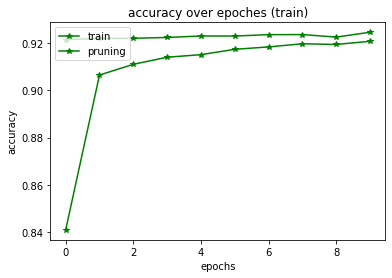

In [6]:
# reset result
y = {}

# Don't forget to reset global statistic, otherwise may cause cuda error
eve.core.State.reset_global_statistic()

# register the global pruning function
eve.core.State.register_global_statistic("l1_norm")

# define net
pruning_neural_network_l1_norm = mnist()

# replace the data_root for your path.
classifier = MnistClassifier(pruning_neural_network_l1_norm)
classifier.prepare_data(data_root= "/home/densechen/dataset")

# use default configuration
classifier.setup_train()

# assign model to trainer
eve.app.trainer.BaseTrainer.assign_model(classifier)

trainer = eve.app.trainer.BaseTrainer()

# Train it
print("===> Train")
train(trainer, "train")

print("===> Pruning")
# use upgrader to do pruning automatically
upgrader = eve.app.upgrader.Upgrader(pruning_neural_network_l1_norm.eve_parameters())
upgrader.step()

train(trainer, "pruning")

plot()

## fire rate

===> Train
Test Accuracy: 92.15%, Elapsed time: 0:00:53.528946
===> Pruning
Test Accuracy: 92.40%, Elapsed time: 0:00:53.454817


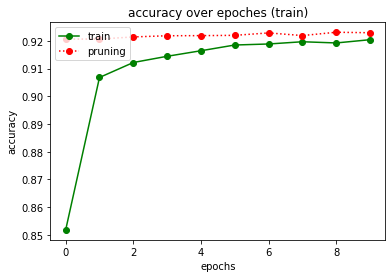

In [7]:
# reset result
y = {}

# Don't forget to reset global statistic, otherwise may cause cuda error
eve.core.State.reset_global_statistic()

# register the global pruning function
eve.core.State.register_global_statistic("fire_rate")

# define net
pruning_neural_network_fire_rate = mnist()

# replace the data_root for your path.
classifier = MnistClassifier(pruning_neural_network_fire_rate)
classifier.prepare_data(data_root="/home/densechen/dataset")

# use default configuration
classifier.setup_train()

# assign model to trainer
eve.app.trainer.BaseTrainer.assign_model(classifier)

trainer = eve.app.trainer.BaseTrainer()

# Train it
print("===> Train")
train(trainer, "train")

print("===> Pruning")
# use upgrader to do pruning automatically
upgrader = eve.app.upgrader.Upgrader(pruning_neural_network_fire_rate.eve_parameters())
upgrader.step()

train(trainer, "pruning")

plot()